In [2]:
import numpy as np 
import math
import numpy.fft as fft
import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
from matplotlib import cm  
import scipy.integrate 
import pandas as pd

/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_13275/810113015.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [59]:
#Defining constants:
#3D to 2D lengthscale in um
h = 0.01
VAratio=1.91

#Define System geometry: A in um2, V in um3
Atotal=4.34
Acluster=0.023
Volume=Atotal*VAratio
scalar = 602.0 # convert the units of dynamin/receptor/etc concentrations from molecules per cubic micron to micromolar

#Dimensionality factor, should be the same in dense and dilute
gamma = Volume/(Atotal*h) #191


tMax = 8.5
expDt=0.02 
targetIncrease=45
nTimePoints=int(tMax/expDt)
timePoints=[i*expDt for i in range(nTimePoints)] 
expdata_unfiltered = pd.read_table("/Users/cmdb/Desktop/JOHNSON_rotation/dynamin_model/PythonCode/RAWDATA/Dynamin1AB_kinetics_RawData.csv", header=None,sep=',',names=['time','expInt', 'expSEM'])
expdata_0 = expdata_unfiltered[(expdata_unfiltered['time'] >= -4.00) & (expdata_unfiltered['time'] <= 4)]
new_index = range(len(expdata_0))
expdata = expdata_0.set_index(pd.Index(new_index))
startToZero = 4 
expTime = expdata['time'] + startToZero 

#make relative intensity higher!
delIntensity=(np.max(expdata['expInt'])-targetIncrease*expdata['expInt'][0])/(1.0-targetIncrease)
print('delIntensity HAS A VALUE OF: '+str(delIntensity))



Dsol0 = 15.43
Dmem0_2D = 74
GTPconc = 120




# kinetic parameters
kfDRC= 2.06515731e-02
RdiluteDens = 6.55374065e+00
kfDydy = kfDRC * 0.78592423 #kfDRC * candidate[2]
RclusDens= 385.7179888 #Dmem0_2D / candidate[3] 
kfDRD = 7.01618503e-02
kfhyd = 0.0033  #NO IDEA WHAT TO SET TO
candidate=np.array([kfDRC, RdiluteDens, 0.78592423, 0.19185001, kfDRD, kfhyd]) # NO IDEA WHERE VALUES FOR CANDIDATE[2] AND [3] ARE COMING FROM....


# species concentrations
Dmem0=Dmem0_2D*Atotal/Volume/scalar 
Rclus0=RclusDens*Acluster/Volume/scalar
Rdilute0=RdiluteDens*Atotal/Volume/scalar
D2Dclus = 0
Dclus = 0
initValues=np.array([Dsol0, Dmem0, Rclus0, Rdilute0, D2Dclus, Dclus])


delIntensity HAS A VALUE OF: 1933.0938181818185


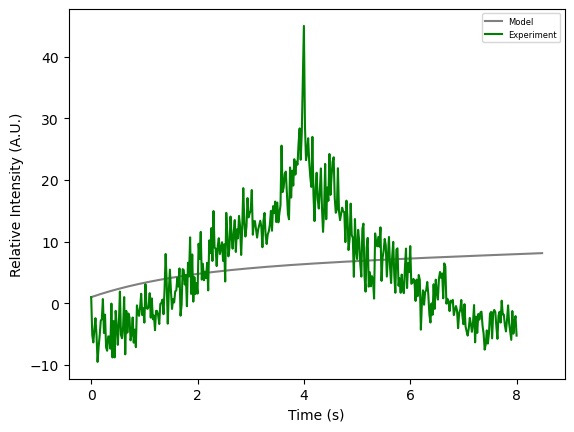

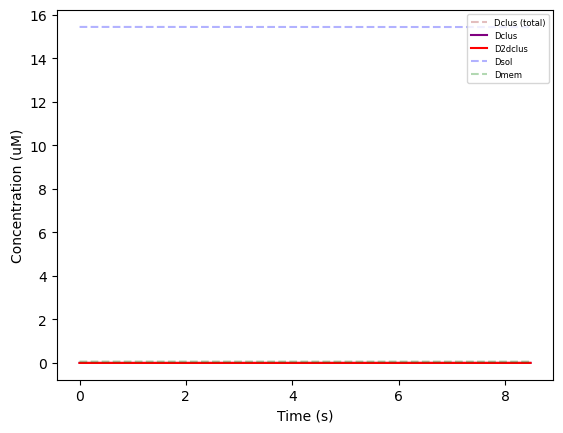

In [61]:
def dynaminODE(t, y, rateParams): 
    # Rate constants
    kfDRC=rateParams[0] #rate binding to activator in cluster, irreversible
    kfDRD=rateParams[1] #rate binding to dilute recruiter from solution
    kbDRD=rateParams[2] #rate of UNbinding from membrane - seems to be used to unbind from dynamin Dmem0
    gamma=rateParams[3] #a demensionality factor taking into account the volume and area of the system
    kfDydy=rateParams[4] #rate constant for dynamin-to-dynamin assembly
    # new parameters for disassembly
    kfhyd=rateParams[5] #rate of hydrolysis of final dynamin helix
    GTPconc=rateParams[6]
    #n = rateParams[7] If I need to use a hill equation for decay

    # Species ("initValues" called in simulate_pre)
    Dsol0 = y[0]
    Dmem0 = y[1]
    Rclus0 = y[2] #Aclus in paper
    Rdilute0 = y[3] #Rmem in paper
    D2Dclus = y[4]
    Dclus = y[5]

    # 2nd order rate expressions 
    bind3DtoCluster = kfDRC*Dsol0*Rclus0 #rate of dynamin binding to the cluster from solution (3D)
    bind2DtoCluster = kfDRC*gamma*Dmem0*Rclus0 #rate of dynamin binding to the cluster from 2D
    bind3DtoDilute = kfDRD*Dsol0*Rdilute0 #rate of dynamin binding to recruiter (not in cluster) from solution (3D)
    bind2DtoDyn = kfDydy*gamma*Dmem0*D2Dclus #rate of dynamin on membrane binding to dynamin in cluster formed from 2D
    bind2Dto3DDyn = kfDydy*gamma*Dmem0*Dclus #rate of dynamin on membrane binding to dynamin cluster formed from 3D
    bind3DtoDyn = kfDydy*Dsol0*D2Dclus #rate of dynamin binding to 3D dynamin
    bind3Dto3DDyn = kfDydy*Dsol0*Dclus #rate of dynamin binding to 3D dynamin (cluster bound)
    # New, added expressions for rate of Dclus_hydro
    creation_Dclus_hydro = kfhyd*Dclus*GTPconc 
    creation_2Dclus_hydro = kfhyd*D2Dclus*GTPconc
    
    #dynamin in solution - Dsol
    Dsol_ODE = -bind3DtoCluster - bind3DtoDilute + (kbDRD*Dmem0) - bind3DtoDyn - bind3Dto3DDyn 
    #dynamin on membrane - Dmem
    Dmem_ODE = -bind2DtoCluster + bind3DtoDilute - (kbDRD*Dmem0) - bind2DtoDyn - bind2Dto3DDyn 
    #available (unbound) recruiter on the cluster membrane - Aclus
    Aclus_ODE = -bind3DtoCluster - bind2DtoCluster
    #available (unbound) recruiter on the membrane dilute - Rmem
    Rmem_ODE = -bind3DtoDilute + (kbDRD*Dmem0)
    #Dynamin in cluster from 2D  - D2dclus
    D2dclus_ODE = bind2DtoCluster + bind2DtoDyn + bind2Dto3DDyn - creation_2Dclus_hydro 
    #Dynamin in cluster from 3D - Dclus
    Dclus_ODE = bind3DtoCluster + bind3DtoDyn + bind3Dto3DDyn - creation_Dclus_hydro
    
    dydt=np.array([Dsol_ODE, Dmem_ODE, Aclus_ODE, Rmem_ODE, D2dclus_ODE, Dclus_ODE])
    return(dydt)


def simulate(candidate, initValues):

        # rate constants for model (s^-1)
		kfDRC=candidate[0] #binding to cluster activator, irreversible
		kfDRD=candidate[4] #binding to dilute recruiter is reversible
		kfDydy=kfDRC*candidate[2] #4 is targetRateRatio
		kbDRD=initValues[0]*initValues[3]/initValues[1]*kfDRD;
		kfhyd=candidate[5] #hydrolysis reaction of dynamin 
		rateParams=np.array([kfDRC, kfDRD, kbDRD, gamma, kfDydy, kfhyd, GTPconc])
		
        #Solve the ODE from 0 to tMax (8.5 seconds)
		solution = scipy.integrate.solve_ivp(fun=dynaminODE,method='Radau', t_span=(0, tMax), y0=initValues, t_eval=timePoints, args=(rateParams,), rtol=1e-7, atol=1e-9)
		return solution.y



def plotModel(solutions, showConc = False):     		
    relInt= (expdata['expInt']-delIntensity)/(expdata['expInt'][0]-delIntensity)
    
    copies = solutions*Volume*scalar

    ac=copies[1]/Atotal #Ddilute
    acd=copies[4]/Acluster #Dclus2D
    ad=copies[5]/Acluster #Dclus3D

    intensRatio=np.divide((acd+ad+ac), ac[0])  #relative intensity of dynamin in cluster compared to dilute
    plt.plot(timePoints, intensRatio, color="grey", label='Model')
    plt.plot(expTime, relInt, color="green",label="Experiment")

    plt.xlabel('Time (s)')
    plt.ylabel('Relative Intensity (A.U.)')
    plt.legend(loc = 'upper right', prop={'size': 6})
    plt.show()

    # Concentrations for time series plot
    Dsol=solutions[0]
    Dmem = solutions[1]
    D2dclus = solutions[4]
    Dclus = solutions[5]
    Dclus_total = D2dclus + Dclus
    
    if showConc == True:
        plt.plot(timePoints,Dclus_total, color = 'brown', label = "Dclus (total)", ls = '--', alpha = 0.3)
        plt.plot(timePoints,Dclus, color = 'purple', label = "Dclus")
        plt.plot(timePoints,D2dclus, color = 'red', label = 'D2dclus')
        plt.plot(timePoints,Dsol, color="blue", label = 'Dsol', ls = '--', alpha = 0.3)
        plt.plot(timePoints,Dmem, color = "green", label = "Dmem", ls = '--', alpha = 0.3)

        plt.xlabel('Time (s)')
        plt.ylabel('Concentration (uM)')
        
        plt.legend(loc = 'upper right', prop={'size': 6})
        plt.show()



solutions = simulate(candidate,initValues) 
PLOT = plotModel(solutions, showConc = True)
PLOT
